In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import re

%matplotlib widget

data_path = 'data/'
train_lidar_path = data_path + 'train_lidar/'
train_labels_path = data_path + 'train_infos/'

classes = {
    'Car': 0,
    'Truck': 1,
    'Bus': 2,
    'Pedestrian': 3,
    'Cyclist': 4
}

class_colors = {
    'Car': 'blue',
    'Truck': 'red',
    'Bus': 'green',
    'Pedestrian': 'magenta',
    'Cyclist': 'cyan'
}

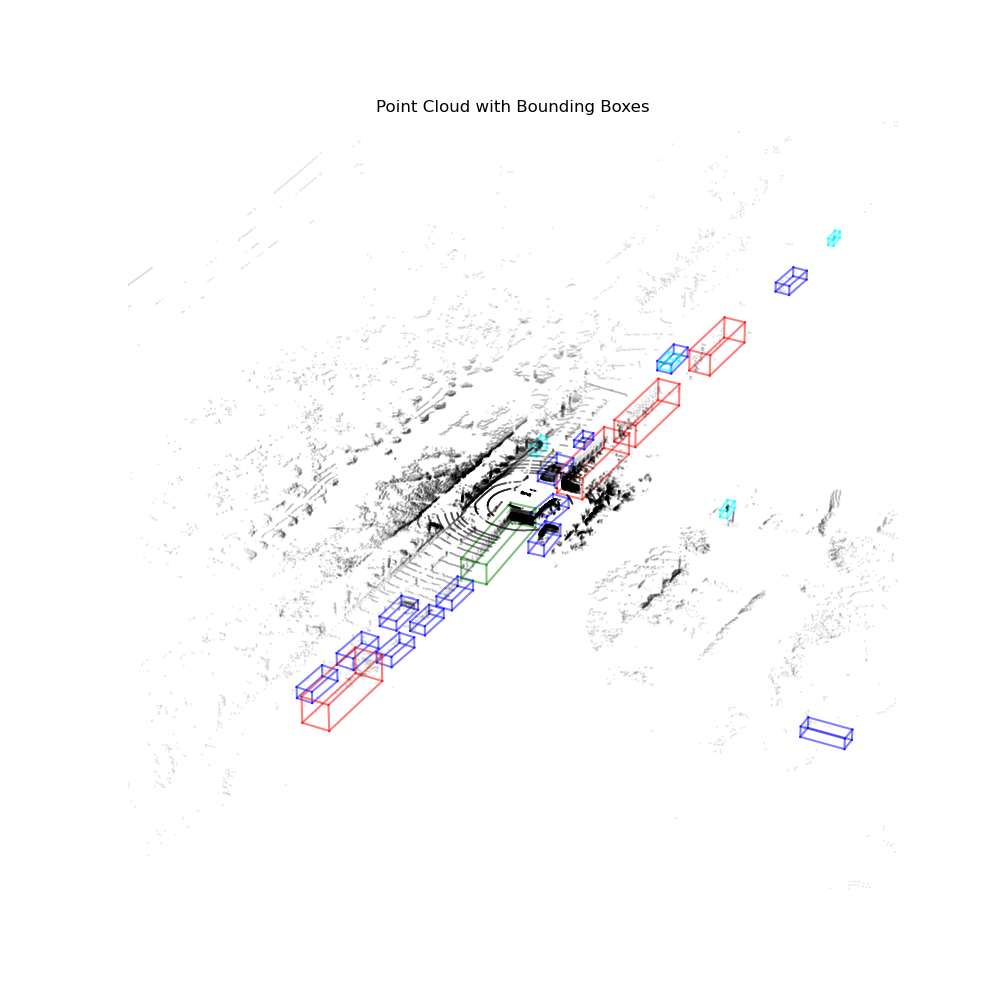

In [17]:
# Read labels from json
scene_set = "000080"
scene_no = 4 # Only even number data points have annotations
flabels = train_labels_path + f"data/{scene_set}/{scene_set}.json"

with open(flabels) as f:
    labels = json.load(f)

# get annotations from first scene
annotations = labels["frames"][scene_no]["annos"]

# create plot
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(10, 10))

# plot all bounding boxes in the scene
for name, box in zip(annotations["names"], annotations["boxes_3d"]):
    # center_x, center_y, center_z, l, w, h, yaw

    # find the corners of the box
    center_x, center_y, center_z, l, w, h, yaw = box

    corners_x = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]]).T
    corners_y = np.array([[w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]]).T
    corners_z = np.array([[h/2, h/2, h/2, h/2, -h/2, -h/2, -h/2, -h/2]]).T
    points = np.hstack((corners_x, corners_y, corners_z))

    # rotation matrix
    R = np.array([[np.cos(-yaw), -np.sin(-yaw), 0],
                  [np.sin(-yaw),  np.cos(-yaw), 0],
                  [           0,             0, 1]])
    # rotate the box
    points = points @ R

    # offset the box with center position
    points[:, 0] += center_x
    points[:, 1] += center_y
    points[:, 2] += center_z

    # colors
    line_c = class_colors[name]

    # plot 12 lines of bounding box
    for i in range(4):
        ax.plot3D(points[[i, i+4], 0], points[[i, i+4], 1], points[[i, i+4], 2], c=line_c, alpha=0.5)
    for i in range(4):
        ax.plot3D(points[[i, (i+1)%4], 0], points[[i, (i+1)%4], 1], points[[i, (i+1)%4], 2], c=line_c, alpha=0.5)
    for i in range(4):
        ax.plot3D(points[[i+4, (i+1)%4+4], 0], points[[i+4, (i+1)%4+4], 1], points[[i+4, (i+1)%4+4], 2], c=line_c, alpha=0.5)

# read point cloud
scene_dir = train_lidar_path + f"data/{scene_set}/lidar_roof/"
all_scenes_pc = [f.path for f in os.scandir(scene_dir) if f.is_file()]
all_scenes_pc.sort(key = lambda x : int(re.sub('\D', '', x)))

point_cloud = np.fromfile(all_scenes_pc[scene_no], dtype=np.float32).reshape(-1, 4)

# plot the point cloud in 3D
ax.scatter3D(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=0.05, c='black', alpha=0.2)

# plot setup
ax.set_aspect('equal', adjustable='box')
ax.set_title('Point Cloud with Bounding Boxes')

lim = (-25, 25)
ax.set_xlim3d(lim[0], lim[1])
ax.set_ylim3d(lim[0], lim[1])
ax.set_zlim3d(lim[0], lim[1])
ax.set_axis_off()

plt.show()